Epoch [10/200], MSE Loss: 0.0252, Accuracy: 87.16%
Epoch [20/200], MSE Loss: 0.0184, Accuracy: 89.12%
Epoch [30/200], MSE Loss: 0.0141, Accuracy: 90.72%
Epoch [40/200], MSE Loss: 0.0154, Accuracy: 90.09%
Epoch [50/200], MSE Loss: 0.0112, Accuracy: 91.72%
Epoch [60/200], MSE Loss: 0.0096, Accuracy: 92.35%
Epoch [70/200], MSE Loss: 0.0092, Accuracy: 92.47%
Epoch [80/200], MSE Loss: 0.0089, Accuracy: 92.58%
Epoch [90/200], MSE Loss: 0.0089, Accuracy: 92.62%
Epoch [100/200], MSE Loss: 0.0088, Accuracy: 92.65%
Epoch [110/200], MSE Loss: 0.0087, Accuracy: 92.68%
Epoch [120/200], MSE Loss: 0.0087, Accuracy: 92.69%
Epoch [130/200], MSE Loss: 0.0086, Accuracy: 92.70%
Epoch [140/200], MSE Loss: 0.0086, Accuracy: 92.70%
Epoch [150/200], MSE Loss: 0.0086, Accuracy: 92.71%
Epoch [160/200], MSE Loss: 0.0086, Accuracy: 92.71%
Epoch [170/200], MSE Loss: 0.0086, Accuracy: 92.71%
Epoch [180/200], MSE Loss: 0.0086, Accuracy: 92.71%
Epoch [190/200], MSE Loss: 0.0086, Accuracy: 92.71%
Epoch [200/200], MSE 

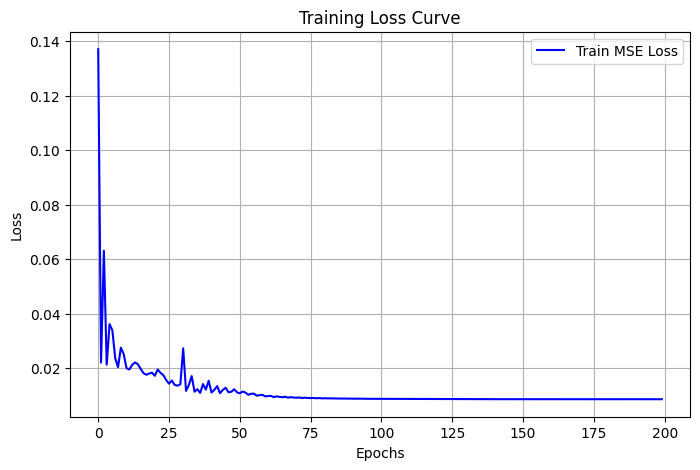

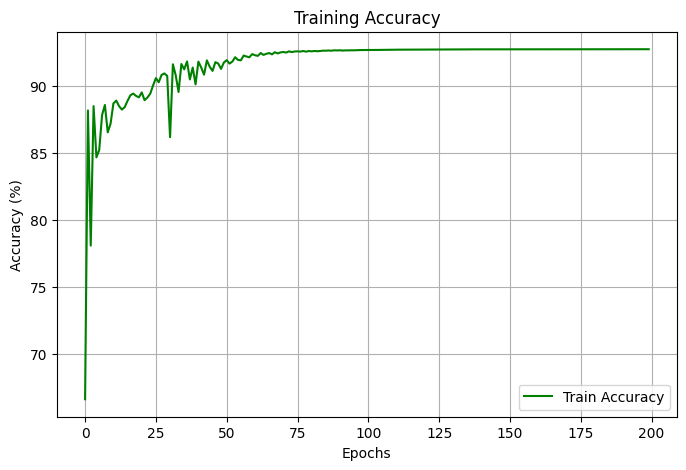

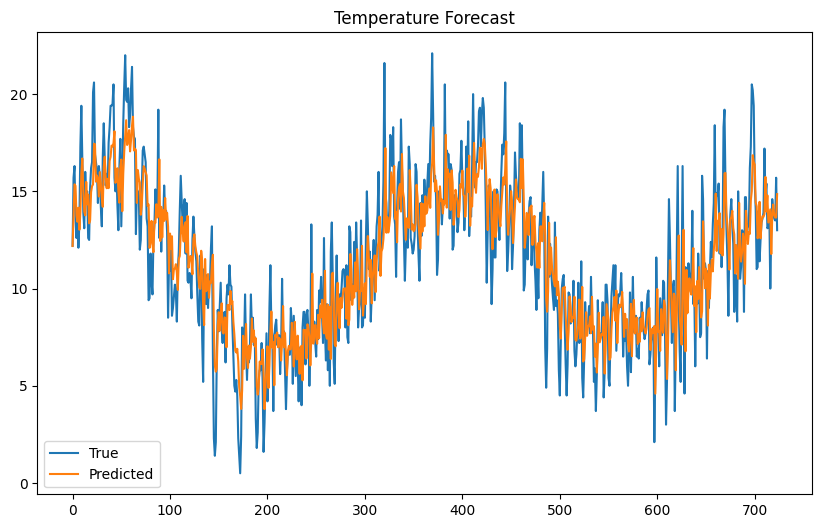

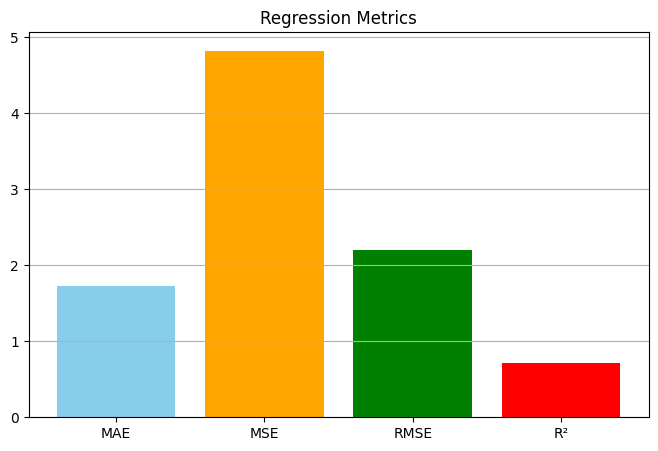


Predicted Next Day Temperature: 14.86°C


In [2]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load temperature dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, usecols=['Temp'])

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['Temp']].values.astype(np.float32))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(data, SEQ_LEN)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, SEQ_LEN, 1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, SEQ_LEN, 1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

# Choose best configuration manually or via grid (let’s use 1 config for now)
hidden_size = 50
num_layers = 1
EPOCHS = 200

model = RNNModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
train_losses = []
train_accuracy_scores = []

for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    mae = torch.mean(torch.abs(output - y_train)).item()
    accuracy = 100 - (mae * 100)
    train_accuracy_scores.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], MSE Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

# Evaluation
model.eval()
with torch.no_grad():
    test_pred = model(X_test).numpy()
    y_test_np = y_test.numpy()
    test_pred = scaler.inverse_transform(test_pred)
    y_test_np = scaler.inverse_transform(y_test_np)

# Regression Metrics
mae = mean_absolute_error(y_test_np, test_pred)
mse = mean_squared_error(y_test_np, test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, test_pred)

print("\nFinal Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Plot 1: Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE Loss", color='blue')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Training Accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracy_scores, label="Train Accuracy", color='green')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: True vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label="True")
plt.plot(test_pred, label="Predicted")
plt.title("Temperature Forecast")
plt.legend()
plt.show()

# Plot 4: Regression Metrics
plt.figure(figsize=(8, 5))
metrics = [mae, mse, rmse, r2]
labels = ['MAE', 'MSE', 'RMSE', 'R²']
colors = ['skyblue', 'orange', 'green', 'red']
plt.bar(labels, metrics, color=colors)
plt.title("Regression Metrics")
plt.grid(True, axis='y')
plt.show()

# Predict next day's temperature
last_seq = X_test[-1].reshape(1, SEQ_LEN, 1)
with torch.no_grad():
    next_temp_scaled = model(last_seq).item()
next_temp = scaler.inverse_transform([[next_temp_scaled]])[0, 0]
print(f"\nPredicted Next Day Temperature: {next_temp:.2f}°C")
